In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:51:50.877425
File: machine_learning_experiment05
Experiment Number: 5


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 1950160822


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment05.ipynb' is assigned to device: cuda:3 with seed 1950160822.


Experiment number: 5 | Seed number: 1950160822
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:51:51,698] A new study created in memory with name: no-name-dfef56af-428e-406e-9614-a3e6c5138103


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:51:54,896] Trial 0 finished with value: 0.7944019996227126 and parameters: {'threshold': 'mean', 'max_features': 171, 'norm_order': 1, 'learning_rate': 0.1457130582411097, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.5776560034944752, 'colsample_bytree': 0.8889846757759481, 'gamma': 2.5480201472907584, 'reg_alpha': 0.35003722437409235, 'reg_lambda': 8.69691832365869, 'n_estimators': 221}. Best is trial 0 with value: 0.7944019996227126.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:51:57,733] Trial 1 finished with value: 0.7004074455309658 and parameters: {'threshold': '0.5*mean', 'max_features': 153, 'norm_order': 2, 'learning_rate': 0.06342799303144069, 'max_depth': 24, 'min_child_weight': 4, 'subsample': 0.9278034361698198, 'colsample_bytree': 0.7045281331937547, 'gamma': 6.600651722084525, 'reg_alpha': 7.702042563786185, 'reg_lambda': 1.0038257459125033, 'n_estimators': 101}. Best is trial 0 with value: 0.7944019996227126.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:00,191] Trial 2 finished with value: 0.6016229429058187 and parameters: {'threshold': 'mean', 'max_features': 329, 'norm_order': 2, 'learning_rate': 0.3030924396739793, 'max_depth': 29, 'min_child_weight': 3, 'subsample': 0.6448246422671804, 'colsample_bytree': 0.5880672322387424, 'gamma': 6.965486468857799, 'reg_alpha': 9.691712820108036, 'reg_lambda': 7.786740609878335, 'n_estimators': 272}. Best is trial 0 with value: 0.7944019996227126.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:02,412] Trial 3 finished with value: 0.7282828282828282 and parameters: {'threshold': '0.5*mean', 'max_features': 136, 'norm_order': 1, 'learning_rate': 0.44606646895468816, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5921460709623689, 'colsample_bytree': 0.6765355493093195, 'gamma': 2.2370949328217336, 'reg_alpha': 4.778179161258295, 'reg_lambda': 3.2453432931354653, 'n_estimators': 270}. Best is trial 0 with value: 0.7944019996227126.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:05,222] Trial 4 finished with value: 0.7241903264891771 and parameters: {'threshold': 'very_low', 'max_features': 972, 'norm_order': 2, 'learning_rate': 0.3426961701272186, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.8830639812453882, 'colsample_bytree': 0.7300109234122364, 'gamma': 6.539321923651052, 'reg_alpha': 5.110602219511273, 'reg_lambda': 3.71050655348643, 'n_estimators': 109}. Best is trial 0 with value: 0.7944019996227126.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:08,016] Trial 5 finished with value: 0.8050045823514008 and parameters: {'threshold': 'very_low', 'max_features': 1012, 'norm_order': 2, 'learning_rate': 0.38493872734889145, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.6949202026695256, 'colsample_bytree': 0.6589366746607697, 'gamma': 5.830583681625981, 'reg_alpha': 0.07760165858737733, 'reg_lambda': 8.621556327359963, 'n_estimators': 92}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:10,700] Trial 6 finished with value: 0.7380525686977301 and parameters: {'threshold': 'mean', 'max_features': 540, 'norm_order': 1, 'learning_rate': 0.08410422323229462, 'max_depth': 27, 'min_child_weight': 7, 'subsample': 0.691700218239492, 'colsample_bytree': 0.9904512373786433, 'gamma': 6.489958754362721, 'reg_alpha': 0.29250408423959096, 'reg_lambda': 7.449538562958239, 'n_estimators': 145}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:13,696] Trial 7 finished with value: 0.7734700601268428 and parameters: {'threshold': '0.5*mean', 'max_features': 400, 'norm_order': 1, 'learning_rate': 0.20798603849391167, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8276064065297217, 'colsample_bytree': 0.8450667229551257, 'gamma': 1.5025194031147593, 'reg_alpha': 7.213731989520812, 'reg_lambda': 9.748657275851548, 'n_estimators': 240}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:17,091] Trial 8 finished with value: 0.7417612659098727 and parameters: {'threshold': 'mean', 'max_features': 467, 'norm_order': 1, 'learning_rate': 0.1363859475422126, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.5583701342487248, 'colsample_bytree': 0.774039368842562, 'gamma': 5.43737180398783, 'reg_alpha': 2.9372321029660964, 'reg_lambda': 1.423016623830753, 'n_estimators': 283}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:20,114] Trial 9 finished with value: 0.7451392947594 and parameters: {'threshold': '1.5*mean', 'max_features': 347, 'norm_order': 1, 'learning_rate': 0.4435127855944836, 'max_depth': 13, 'min_child_weight': 5, 'subsample': 0.574583471655205, 'colsample_bytree': 0.538251242810515, 'gamma': 2.506364279190346, 'reg_alpha': 0.9907831501658482, 'reg_lambda': 9.676916758822992, 'n_estimators': 51}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:22,826] Trial 10 finished with value: 0.6923853923853924 and parameters: {'threshold': 'very_low', 'max_features': 1025, 'norm_order': 2, 'learning_rate': 0.36947066794346545, 'max_depth': 20, 'min_child_weight': 10, 'subsample': 0.7711071164353358, 'colsample_bytree': 0.6358629317196705, 'gamma': 9.866918396899363, 'reg_alpha': 2.5922657446376274, 'reg_lambda': 5.758875136708041, 'n_estimators': 54}. Best is trial 5 with value: 0.8050045823514008.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:26,330] Trial 11 finished with value: 0.8104858104858105 and parameters: {'threshold': 'median', 'max_features': 725, 'norm_order': 2, 'learning_rate': 0.19760291598278507, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.7005464484852058, 'colsample_bytree': 0.9179463153535012, 'gamma': 3.6948386379091014, 'reg_alpha': 0.04919351168297579, 'reg_lambda': 7.397397755837919, 'n_estimators': 207}. Best is trial 11 with value: 0.8104858104858105.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:29,425] Trial 12 finished with value: 0.7822959692351517 and parameters: {'threshold': 'median', 'max_features': 772, 'norm_order': 2, 'learning_rate': 0.2462791441447151, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7238955173316145, 'colsample_bytree': 0.9949952254860044, 'gamma': 3.8736401315719564, 'reg_alpha': 2.2878929914717094, 'reg_lambda': 6.075226277445043, 'n_estimators': 187}. Best is trial 11 with value: 0.8104858104858105.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:32,401] Trial 13 finished with value: 0.7157521250758956 and parameters: {'threshold': 'median', 'max_features': 757, 'norm_order': 2, 'learning_rate': 0.49810333219210506, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.9995335582804219, 'colsample_bytree': 0.8120138567274274, 'gamma': 4.226605714646784, 'reg_alpha': 1.576123309603147, 'reg_lambda': 7.092214231648436, 'n_estimators': 179}. Best is trial 11 with value: 0.8104858104858105.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:36,099] Trial 14 finished with value: 0.7354497354497355 and parameters: {'threshold': 'very_low', 'max_features': 818, 'norm_order': 2, 'learning_rate': 0.2015419760620737, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.7810634413243209, 'colsample_bytree': 0.9106095581767935, 'gamma': 8.50782577423439, 'reg_alpha': 4.172908302610573, 'reg_lambda': 4.4623635907773584, 'n_estimators': 153}. Best is trial 11 with value: 0.8104858104858105.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:39,946] Trial 15 finished with value: 0.8343932082787417 and parameters: {'threshold': 'median', 'max_features': 637, 'norm_order': 2, 'learning_rate': 0.3010605537620431, 'max_depth': 25, 'min_child_weight': 1, 'subsample': 0.6561934815578941, 'colsample_bytree': 0.6256471393486607, 'gamma': 0.03796745009688296, 'reg_alpha': 0.16684308340392975, 'reg_lambda': 8.541969642713248, 'n_estimators': 213}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:43,767] Trial 16 finished with value: 0.8252510985561833 and parameters: {'threshold': 'median', 'max_features': 614, 'norm_order': 2, 'learning_rate': 0.3072650991306337, 'max_depth': 26, 'min_child_weight': 1, 'subsample': 0.5136717476350414, 'colsample_bytree': 0.525716934024851, 'gamma': 0.29705205719819733, 'reg_alpha': 3.6576965486289774, 'reg_lambda': 6.313269652174688, 'n_estimators': 212}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:47,008] Trial 17 finished with value: 0.6345854555744199 and parameters: {'threshold': 'median', 'max_features': 629, 'norm_order': 2, 'learning_rate': 0.2960413527043886, 'max_depth': 30, 'min_child_weight': 10, 'subsample': 0.5024997513700871, 'colsample_bytree': 0.5086962760009326, 'gamma': 0.245869796106416, 'reg_alpha': 3.8348306608241884, 'reg_lambda': 5.81703937819834, 'n_estimators': 242}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:50,340] Trial 18 finished with value: 0.7618623872365854 and parameters: {'threshold': 'median', 'max_features': 631, 'norm_order': 2, 'learning_rate': 0.29694556766998015, 'max_depth': 26, 'min_child_weight': 3, 'subsample': 0.509815701989673, 'colsample_bytree': 0.5894313762966836, 'gamma': 0.8541785422961103, 'reg_alpha': 6.229708232129799, 'reg_lambda': 8.59161637809527, 'n_estimators': 211}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:54,195] Trial 19 finished with value: 0.7797017797017797 and parameters: {'threshold': '1.5*mean', 'max_features': 579, 'norm_order': 2, 'learning_rate': 0.2570591916720338, 'max_depth': 26, 'min_child_weight': 6, 'subsample': 0.6400556847006228, 'colsample_bytree': 0.5833506782710384, 'gamma': 0.19200727976037565, 'reg_alpha': 3.4295796437174464, 'reg_lambda': 2.4121755185677305, 'n_estimators': 152}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:52:57,222] Trial 20 finished with value: 0.7046325322187391 and parameters: {'threshold': 'median', 'max_features': 894, 'norm_order': 2, 'learning_rate': 0.42275473730923374, 'max_depth': 23, 'min_child_weight': 9, 'subsample': 0.6411438926340913, 'colsample_bytree': 0.5353150707625606, 'gamma': 1.333078006079279, 'reg_alpha': 1.6854788798586473, 'reg_lambda': 6.507404939802511, 'n_estimators': 239}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:00,977] Trial 21 finished with value: 0.7847704245525321 and parameters: {'threshold': 'median', 'max_features': 677, 'norm_order': 2, 'learning_rate': 0.1623857043180975, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.684461718821831, 'colsample_bytree': 0.6111732111587856, 'gamma': 3.91916852652871, 'reg_alpha': 1.353408254170497, 'reg_lambda': 4.93474024856614, 'n_estimators': 209}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:05,008] Trial 22 finished with value: 0.7780185722441656 and parameters: {'threshold': 'median', 'max_features': 700, 'norm_order': 2, 'learning_rate': 0.02147350504430337, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8014619417536731, 'colsample_bytree': 0.5000526162199082, 'gamma': 3.1696802935157, 'reg_alpha': 0.8415719879429915, 'reg_lambda': 8.085673687309384, 'n_estimators': 201}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:07,879] Trial 23 finished with value: 0.7989151305683565 and parameters: {'threshold': 'median', 'max_features': 855, 'norm_order': 2, 'learning_rate': 0.23830232246602545, 'max_depth': 28, 'min_child_weight': 3, 'subsample': 0.6177382570817872, 'colsample_bytree': 0.7675450701965154, 'gamma': 1.2907462330361126, 'reg_alpha': 2.2446517690231174, 'reg_lambda': 6.793784942613267, 'n_estimators': 254}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:11,614] Trial 24 finished with value: 0.8073815073815074 and parameters: {'threshold': 'median', 'max_features': 482, 'norm_order': 2, 'learning_rate': 0.32050726765482346, 'max_depth': 25, 'min_child_weight': 2, 'subsample': 0.7293294766866155, 'colsample_bytree': 0.9119912099103995, 'gamma': 0.06982152832395272, 'reg_alpha': 5.801401767982077, 'reg_lambda': 9.223328548878815, 'n_estimators': 299}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:15,705] Trial 25 finished with value: 0.771886720790011 and parameters: {'threshold': 'median', 'max_features': 730, 'norm_order': 2, 'learning_rate': 0.19160043355803594, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.5240281961787171, 'colsample_bytree': 0.55410401151084, 'gamma': 1.9020399521473013, 'reg_alpha': 8.292046799306004, 'reg_lambda': 7.727332923665374, 'n_estimators': 186}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:19,634] Trial 26 finished with value: 0.726474578976774 and parameters: {'threshold': 'median', 'max_features': 9, 'norm_order': 2, 'learning_rate': 0.26776448148152293, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.5420801156262419, 'colsample_bytree': 0.6373988473201906, 'gamma': 3.357496896090653, 'reg_alpha': 3.2583727604601522, 'reg_lambda': 5.4324366297590485, 'n_estimators': 163}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:23,017] Trial 27 finished with value: 0.7504245389113811 and parameters: {'threshold': '1.5*mean', 'max_features': 925, 'norm_order': 2, 'learning_rate': 0.3474764568529647, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.8360747027195476, 'colsample_bytree': 0.6863091228678233, 'gamma': 4.801710334302396, 'reg_alpha': 0.8660899718188302, 'reg_lambda': 6.705368486999425, 'n_estimators': 215}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:26,719] Trial 28 finished with value: 0.7653689284390063 and parameters: {'threshold': 'median', 'max_features': 584, 'norm_order': 2, 'learning_rate': 0.39306265025681875, 'max_depth': 21, 'min_child_weight': 5, 'subsample': 0.667826155496481, 'colsample_bytree': 0.8289471639547288, 'gamma': 0.7983260695243675, 'reg_alpha': 2.024271871039084, 'reg_lambda': 4.512772329011179, 'n_estimators': 120}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:30,382] Trial 29 finished with value: 0.8240131453246208 and parameters: {'threshold': 'median', 'max_features': 277, 'norm_order': 1, 'learning_rate': 0.1499930123809734, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6107626577588268, 'colsample_bytree': 0.8716702218216281, 'gamma': 2.9350683003464124, 'reg_alpha': 0.009893089015285496, 'reg_lambda': 8.250088628760926, 'n_estimators': 225}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:33,948] Trial 30 finished with value: 0.7799522617723396 and parameters: {'threshold': 'median', 'max_features': 264, 'norm_order': 1, 'learning_rate': 0.15080312030980964, 'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.5979790025604109, 'colsample_bytree': 0.8654845169488424, 'gamma': 3.0269173248127283, 'reg_alpha': 0.7856639482349728, 'reg_lambda': 8.989962901733806, 'n_estimators': 226}. Best is trial 15 with value: 0.8343932082787417.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:37,312] Trial 31 finished with value: 0.8350168350168351 and parameters: {'threshold': 'median', 'max_features': 453, 'norm_order': 1, 'learning_rate': 0.2149830192808046, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.727027416341902, 'colsample_bytree': 0.9534525371308229, 'gamma': 1.9269046131790768, 'reg_alpha': 0.15630847014543664, 'reg_lambda': 8.260026385810274, 'n_estimators': 203}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:41,258] Trial 32 finished with value: 0.8254386400914558 and parameters: {'threshold': 'median', 'max_features': 430, 'norm_order': 1, 'learning_rate': 0.10900226485127808, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7431981588938575, 'colsample_bytree': 0.9306419608767997, 'gamma': 0.7912170857202669, 'reg_alpha': 0.5904346999190819, 'reg_lambda': 8.294876491679522, 'n_estimators': 194}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:45,513] Trial 33 finished with value: 0.8272678382234074 and parameters: {'threshold': '0.5*mean', 'max_features': 423, 'norm_order': 1, 'learning_rate': 0.09565933718300156, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.7440562402234546, 'colsample_bytree': 0.962469207539029, 'gamma': 0.7404993075790839, 'reg_alpha': 1.3195599558938103, 'reg_lambda': 9.255353794209308, 'n_estimators': 196}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:49,508] Trial 34 finished with value: 0.7838468061051441 and parameters: {'threshold': '0.5*mean', 'max_features': 398, 'norm_order': 1, 'learning_rate': 0.10194214116705928, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.7298960888682575, 'colsample_bytree': 0.9490641772360753, 'gamma': 1.848745242648358, 'reg_alpha': 1.3051304689422183, 'reg_lambda': 9.313289886771374, 'n_estimators': 195}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:53,369] Trial 35 finished with value: 0.795685096529929 and parameters: {'threshold': '0.5*mean', 'max_features': 462, 'norm_order': 1, 'learning_rate': 0.015059628758065546, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7497398868405912, 'colsample_bytree': 0.9612902694975726, 'gamma': 0.7378083042244379, 'reg_alpha': 0.6522100841769448, 'reg_lambda': 9.838042993591015, 'n_estimators': 170}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:53:56,927] Trial 36 finished with value: 0.7781040881330177 and parameters: {'threshold': '0.5*mean', 'max_features': 249, 'norm_order': 1, 'learning_rate': 0.05269382387628034, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8702981049524168, 'colsample_bytree': 0.9595730193536293, 'gamma': 2.18282245938423, 'reg_alpha': 1.7950289819521603, 'reg_lambda': 8.221436655048459, 'n_estimators': 138}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:00,701] Trial 37 finished with value: 0.8314827892864617 and parameters: {'threshold': '0.5*mean', 'max_features': 408, 'norm_order': 1, 'learning_rate': 0.11382553643883826, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.761062296912555, 'colsample_bytree': 0.7249443377662491, 'gamma': 0.8557841459792053, 'reg_alpha': 0.6066765998296985, 'reg_lambda': 0.22733386203574124, 'n_estimators': 258}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:05,036] Trial 38 finished with value: 0.8165767847971237 and parameters: {'threshold': '0.5*mean', 'max_features': 529, 'norm_order': 1, 'learning_rate': 0.05975673477869772, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.7821005144468758, 'colsample_bytree': 0.7180211839191052, 'gamma': 1.4414318283582344, 'reg_alpha': 1.2302300859380821, 'reg_lambda': 0.608564434641561, 'n_estimators': 264}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:08,788] Trial 39 finished with value: 0.7306423692743871 and parameters: {'threshold': '0.5*mean', 'max_features': 342, 'norm_order': 1, 'learning_rate': 0.12365100056047232, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6698859341250896, 'colsample_bytree': 0.7891467535494968, 'gamma': 2.6438141268458004, 'reg_alpha': 9.945053959515894, 'reg_lambda': 1.9577489967960486, 'n_estimators': 251}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:13,130] Trial 40 finished with value: 0.8030303030303031 and parameters: {'threshold': '0.5*mean', 'max_features': 206, 'norm_order': 1, 'learning_rate': 0.0756179648517584, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.8275968378987806, 'colsample_bytree': 0.737178455143146, 'gamma': 1.7505609718483615, 'reg_alpha': 2.872737533316692, 'reg_lambda': 3.225650493138359, 'n_estimators': 284}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:17,601] Trial 41 finished with value: 0.8242945326278659 and parameters: {'threshold': 'mean', 'max_features': 403, 'norm_order': 1, 'learning_rate': 0.11520997336142785, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7540825740798618, 'colsample_bytree': 0.9756910947854536, 'gamma': 0.920096552457904, 'reg_alpha': 0.40605319729128503, 'reg_lambda': 8.528326099316267, 'n_estimators': 228}. Best is trial 31 with value: 0.8350168350168351.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:21,171] Trial 42 finished with value: 0.8362777628314352 and parameters: {'threshold': '0.5*mean', 'max_features': 443, 'norm_order': 1, 'learning_rate': 0.18020951458818607, 'max_depth': 12, 'min_child_weight': 4, 'subsample': 0.7109961573739306, 'colsample_bytree': 0.9327149718288029, 'gamma': 0.6153284886370738, 'reg_alpha': 0.36332386133500894, 'reg_lambda': 9.015062546283966, 'n_estimators': 191}. Best is trial 42 with value: 0.8362777628314352.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:25,434] Trial 43 finished with value: 0.8024393168542404 and parameters: {'threshold': '0.5*mean', 'max_features': 504, 'norm_order': 1, 'learning_rate': 0.17460844774234077, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.7081750248865195, 'colsample_bytree': 0.8750771715136121, 'gamma': 0.514552876335733, 'reg_alpha': 0.29613275527472294, 'reg_lambda': 0.23629071375613986, 'n_estimators': 167}. Best is trial 42 with value: 0.8362777628314352.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:29,424] Trial 44 finished with value: 0.8150325758779596 and parameters: {'threshold': '0.5*mean', 'max_features': 366, 'norm_order': 1, 'learning_rate': 0.23144178484893965, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.6635096377216139, 'colsample_bytree': 0.6974205944487257, 'gamma': 1.1367975054123325, 'reg_alpha': 0.007959949048083448, 'reg_lambda': 9.051386000160129, 'n_estimators': 182}. Best is trial 42 with value: 0.8362777628314352.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:33,379] Trial 45 finished with value: 0.8703440217204523 and parameters: {'threshold': '0.5*mean', 'max_features': 543, 'norm_order': 1, 'learning_rate': 0.277782187818752, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8118061248435045, 'colsample_bytree': 0.6596493191016018, 'gamma': 0.031064622714136982, 'reg_alpha': 1.0016564464303734, 'reg_lambda': 9.969520397005727, 'n_estimators': 231}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:37,498] Trial 46 finished with value: 0.8554164952895783 and parameters: {'threshold': '0.5*mean', 'max_features': 554, 'norm_order': 1, 'learning_rate': 0.27263424573814127, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8052320619232111, 'colsample_bytree': 0.6218527840206548, 'gamma': 0.01745027822071088, 'reg_alpha': 2.498394203454255, 'reg_lambda': 9.98920985976596, 'n_estimators': 235}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:42,283] Trial 47 finished with value: 0.7687830687830687 and parameters: {'threshold': 'mean', 'max_features': 547, 'norm_order': 1, 'learning_rate': 0.28006966883748774, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8768042071068916, 'colsample_bytree': 0.653754708288911, 'gamma': 0.03251386479693728, 'reg_alpha': 4.529600131900553, 'reg_lambda': 9.834013983708292, 'n_estimators': 235}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:46,373] Trial 48 finished with value: 0.7236297400231826 and parameters: {'threshold': 'very_low', 'max_features': 667, 'norm_order': 1, 'learning_rate': 0.22150020507851303, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.9186537824345709, 'colsample_bytree': 0.6178519372549357, 'gamma': 7.3119580619782205, 'reg_alpha': 2.5784429534063733, 'reg_lambda': 9.95822518823974, 'n_estimators': 275}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:50,439] Trial 49 finished with value: 0.8088443634891722 and parameters: {'threshold': '0.5*mean', 'max_features': 572, 'norm_order': 1, 'learning_rate': 0.3313544076955057, 'max_depth': 13, 'min_child_weight': 4, 'subsample': 0.8037080449457054, 'colsample_bytree': 0.6706241057776489, 'gamma': 0.023286912667803323, 'reg_alpha': 1.928416585050855, 'reg_lambda': 7.584802043184258, 'n_estimators': 221}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:53,572] Trial 50 finished with value: 0.8136852394916912 and parameters: {'threshold': '1.5*mean', 'max_features': 505, 'norm_order': 1, 'learning_rate': 0.27590472981181025, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.8398504994328412, 'colsample_bytree': 0.5911034242970991, 'gamma': 2.2073412189743493, 'reg_alpha': 1.0617128067408526, 'reg_lambda': 8.834319806350566, 'n_estimators': 250}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:54:57,338] Trial 51 finished with value: 0.8296370746002982 and parameters: {'threshold': '0.5*mean', 'max_features': 459, 'norm_order': 1, 'learning_rate': 0.2128379408674851, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8004837241587514, 'colsample_bytree': 0.7077248707993152, 'gamma': 1.1931410070787354, 'reg_alpha': 0.46707292494894204, 'reg_lambda': 9.478533208429663, 'n_estimators': 258}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:01,707] Trial 52 finished with value: 0.8545454545454545 and parameters: {'threshold': '0.5*mean', 'max_features': 302, 'norm_order': 1, 'learning_rate': 0.1728625775969774, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7626718393065546, 'colsample_bytree': 0.6618647482830872, 'gamma': 0.5045217910725558, 'reg_alpha': 0.4860555011406964, 'reg_lambda': 7.209083042449923, 'n_estimators': 243}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:05,671] Trial 53 finished with value: 0.8547469302186284 and parameters: {'threshold': '0.5*mean', 'max_features': 312, 'norm_order': 1, 'learning_rate': 0.1805500652510615, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7144162602201275, 'colsample_bytree': 0.5668561107255926, 'gamma': 0.5214433399927694, 'reg_alpha': 1.4360456870165978, 'reg_lambda': 7.069163297590091, 'n_estimators': 237}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:10,288] Trial 54 finished with value: 0.8381912039854827 and parameters: {'threshold': '0.5*mean', 'max_features': 306, 'norm_order': 1, 'learning_rate': 0.17009410633354344, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7112292651211416, 'colsample_bytree': 0.5626334371460481, 'gamma': 0.5138582160615668, 'reg_alpha': 1.6165154421358232, 'reg_lambda': 7.131243443289854, 'n_estimators': 235}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:14,703] Trial 55 finished with value: 0.8345959595959597 and parameters: {'threshold': '0.5*mean', 'max_features': 298, 'norm_order': 1, 'learning_rate': 0.18934737937556295, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7085692792021687, 'colsample_bytree': 0.5774232715154619, 'gamma': 0.46421548808519203, 'reg_alpha': 2.417085344733386, 'reg_lambda': 7.148110048675374, 'n_estimators': 242}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:18,428] Trial 56 finished with value: 0.8177316194734227 and parameters: {'threshold': '0.5*mean', 'max_features': 157, 'norm_order': 1, 'learning_rate': 0.13649321825651378, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7863511415515412, 'colsample_bytree': 0.5646061046912134, 'gamma': 1.5430466021235052, 'reg_alpha': 1.681203760311314, 'reg_lambda': 7.125093794367066, 'n_estimators': 233}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:22,120] Trial 57 finished with value: 0.7711548987411057 and parameters: {'threshold': '0.5*mean', 'max_features': 227, 'norm_order': 1, 'learning_rate': 0.1828834588201331, 'max_depth': 13, 'min_child_weight': 8, 'subsample': 0.6862504281854079, 'colsample_bytree': 0.6551486240857306, 'gamma': 0.43649045878222203, 'reg_alpha': 2.1771162973718896, 'reg_lambda': 5.928071792814369, 'n_estimators': 71}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:25,935] Trial 58 finished with value: 0.8133188242743934 and parameters: {'threshold': '0.5*mean', 'max_features': 103, 'norm_order': 1, 'learning_rate': 0.16983166162949276, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8178650731644288, 'colsample_bytree': 0.5455106190381582, 'gamma': 0.4888797555461815, 'reg_alpha': 3.0265267389683355, 'reg_lambda': 9.584390075920949, 'n_estimators': 244}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:29,804] Trial 59 finished with value: 0.7574978379046207 and parameters: {'threshold': '0.5*mean', 'max_features': 319, 'norm_order': 1, 'learning_rate': 0.2532620541607371, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7744181762285952, 'colsample_bytree': 0.5207825655722478, 'gamma': 5.863960429605989, 'reg_alpha': 1.6556577526904772, 'reg_lambda': 7.956896786452818, 'n_estimators': 270}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:32,856] Trial 60 finished with value: 0.7724920476665242 and parameters: {'threshold': '0.5*mean', 'max_features': 368, 'norm_order': 1, 'learning_rate': 0.23812132058039628, 'max_depth': 17, 'min_child_weight': 6, 'subsample': 0.9090593774332844, 'colsample_bytree': 0.605291662561358, 'gamma': 1.1121820020487787, 'reg_alpha': 9.081461597438302, 'reg_lambda': 5.462474633630053, 'n_estimators': 219}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:36,593] Trial 61 finished with value: 0.8320299771912675 and parameters: {'threshold': 'very_low', 'max_features': 97, 'norm_order': 1, 'learning_rate': 0.20102246795347012, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.7219943328355973, 'colsample_bytree': 0.6306021749063504, 'gamma': 0.4444049666798115, 'reg_alpha': 1.0626155316327401, 'reg_lambda': 7.385904685055478, 'n_estimators': 206}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:40,231] Trial 62 finished with value: 0.824077468230694 and parameters: {'threshold': '0.5*mean', 'max_features': 309, 'norm_order': 1, 'learning_rate': 0.22444520012227334, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7169281480807954, 'colsample_bytree': 0.6014097984265061, 'gamma': 1.6640227844226982, 'reg_alpha': 1.4492695166295828, 'reg_lambda': 8.711954052558823, 'n_estimators': 229}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:44,352] Trial 63 finished with value: 0.8458861597394871 and parameters: {'threshold': '0.5*mean', 'max_features': 215, 'norm_order': 1, 'learning_rate': 0.15371419510203224, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.6948061945918602, 'colsample_bytree': 0.5621389574837785, 'gamma': 0.002572663689814198, 'reg_alpha': 1.0481054891345587, 'reg_lambda': 6.824194890015527, 'n_estimators': 203}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:48,717] Trial 64 finished with value: 0.841378263509411 and parameters: {'threshold': '0.5*mean', 'max_features': 183, 'norm_order': 1, 'learning_rate': 0.14930865423918246, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8623277398144441, 'colsample_bytree': 0.5661097829452902, 'gamma': 0.3010356656499301, 'reg_alpha': 0.9380325120532081, 'reg_lambda': 7.020744185636285, 'n_estimators': 246}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:52,181] Trial 65 finished with value: 0.8423430735930736 and parameters: {'threshold': '0.5*mean', 'max_features': 118, 'norm_order': 1, 'learning_rate': 0.15973264501024118, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8575253627396191, 'colsample_bytree': 0.5689257026743855, 'gamma': 0.28571083734244807, 'reg_alpha': 2.020353815352434, 'reg_lambda': 6.514434739802394, 'n_estimators': 243}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:55:56,838] Trial 66 finished with value: 0.8580312722103768 and parameters: {'threshold': '0.5*mean', 'max_features': 40, 'norm_order': 1, 'learning_rate': 0.13294956388172022, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.8866847122813284, 'colsample_bytree': 0.5738678693648285, 'gamma': 0.20704042457851263, 'reg_alpha': 2.838479916761208, 'reg_lambda': 6.185291933213375, 'n_estimators': 248}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:00,714] Trial 67 finished with value: 0.7277408281484661 and parameters: {'threshold': '0.5*mean', 'max_features': 13, 'norm_order': 1, 'learning_rate': 0.134754259250091, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9511699438909378, 'colsample_bytree': 0.5308051364356428, 'gamma': 7.930532867277823, 'reg_alpha': 2.795625366637579, 'reg_lambda': 6.22491878667924, 'n_estimators': 284}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:03,943] Trial 68 finished with value: 0.7401111650747397 and parameters: {'threshold': 'mean', 'max_features': 53, 'norm_order': 1, 'learning_rate': 0.16033396856030183, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.8546637650973103, 'colsample_bytree': 0.6487185791409209, 'gamma': 9.660280562892403, 'reg_alpha': 3.7829855734749427, 'reg_lambda': 6.490156658934193, 'n_estimators': 267}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:07,211] Trial 69 finished with value: 0.7979073893052387 and parameters: {'threshold': '1.5*mean', 'max_features': 89, 'norm_order': 1, 'learning_rate': 0.08351139341989111, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.8912052269257899, 'colsample_bytree': 0.5771378980013452, 'gamma': 1.055598358549883, 'reg_alpha': 3.352554935605245, 'reg_lambda': 4.730610005501777, 'n_estimators': 276}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:10,424] Trial 70 finished with value: 0.7976430976430976 and parameters: {'threshold': '0.5*mean', 'max_features': 131, 'norm_order': 1, 'learning_rate': 0.12861569345046156, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.9371811031048742, 'colsample_bytree': 0.5955486562085879, 'gamma': 0.20220434196389, 'reg_alpha': 5.633316357633546, 'reg_lambda': 5.692708836321675, 'n_estimators': 261}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:14,536] Trial 71 finished with value: 0.8351254480286738 and parameters: {'threshold': '0.5*mean', 'max_features': 187, 'norm_order': 1, 'learning_rate': 0.14725455141286276, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8528075248414908, 'colsample_bytree': 0.552962210109534, 'gamma': 0.19313597408654934, 'reg_alpha': 1.950165099095984, 'reg_lambda': 6.7870301330688205, 'n_estimators': 247}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:18,633] Trial 72 finished with value: 0.8672128349547704 and parameters: {'threshold': '0.5*mean', 'max_features': 51, 'norm_order': 1, 'learning_rate': 0.1599938817689138, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.8578236909969051, 'colsample_bytree': 0.514063307554159, 'gamma': 0.061312886156107416, 'reg_alpha': 2.4289049045071383, 'reg_lambda': 6.453408329370686, 'n_estimators': 219}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:21,843] Trial 73 finished with value: 0.8284333658642377 and parameters: {'threshold': '0.5*mean', 'max_features': 44, 'norm_order': 1, 'learning_rate': 0.26198168119949905, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.8085769453267733, 'colsample_bytree': 0.5144457308870821, 'gamma': 0.019695800197214952, 'reg_alpha': 2.5017659399315133, 'reg_lambda': 6.2639959362348385, 'n_estimators': 217}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:25,138] Trial 74 finished with value: 0.789284145805885 and parameters: {'threshold': '0.5*mean', 'max_features': 134, 'norm_order': 1, 'learning_rate': 0.2919574296052429, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.9033764720658245, 'colsample_bytree': 0.5009737561982337, 'gamma': 1.3593226856928666, 'reg_alpha': 7.075779342075992, 'reg_lambda': 6.441548182146525, 'n_estimators': 235}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:28,893] Trial 75 finished with value: 0.80812324929972 and parameters: {'threshold': '0.5*mean', 'max_features': 62, 'norm_order': 1, 'learning_rate': 0.19715218006640772, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.8885690107747829, 'colsample_bytree': 0.5402891191853572, 'gamma': 0.7323429406096985, 'reg_alpha': 4.2440348625174575, 'reg_lambda': 4.011325151868529, 'n_estimators': 222}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:31,534] Trial 76 finished with value: 0.1398692810457516 and parameters: {'threshold': '0.5*mean', 'max_features': 1, 'norm_order': 1, 'learning_rate': 0.31779400013425446, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.8477038596573815, 'colsample_bytree': 0.6182125422709769, 'gamma': 0.0011150526143429013, 'reg_alpha': 2.269297492267225, 'reg_lambda': 5.331998039366879, 'n_estimators': 254}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:35,195] Trial 77 finished with value: 0.8490120467521597 and parameters: {'threshold': 'very_low', 'max_features': 217, 'norm_order': 1, 'learning_rate': 0.35241872714754097, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8202211301351026, 'colsample_bytree': 0.6384949462424857, 'gamma': 0.960977756289453, 'reg_alpha': 2.0538459738678294, 'reg_lambda': 5.102789092445671, 'n_estimators': 212}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:37,980] Trial 78 finished with value: 0.7761441670305244 and parameters: {'threshold': 'very_low', 'max_features': 232, 'norm_order': 1, 'learning_rate': 0.36163588588213486, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8197360666952783, 'colsample_bytree': 0.6844624750877673, 'gamma': 4.613811388161238, 'reg_alpha': 3.0287799611064035, 'reg_lambda': 7.856948707105241, 'n_estimators': 209}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:39,599] Trial 79 finished with value: 0.8349421070732547 and parameters: {'threshold': 'very_low', 'max_features': 159, 'norm_order': 1, 'learning_rate': 0.4536029256916897, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7660849798053907, 'colsample_bytree': 0.6395084728880754, 'gamma': 0.9969272742058464, 'reg_alpha': 1.1788748654418177, 'reg_lambda': 5.116798991873152, 'n_estimators': 202}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:41,910] Trial 80 finished with value: 0.8441687344913151 and parameters: {'threshold': 'very_low', 'max_features': 612, 'norm_order': 1, 'learning_rate': 0.3979701432497975, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8347157404913517, 'colsample_bytree': 0.6115119414720273, 'gamma': 0.6566356547735451, 'reg_alpha': 1.4559622967827377, 'reg_lambda': 5.941814505186365, 'n_estimators': 215}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:45,057] Trial 81 finished with value: 0.8198783379729869 and parameters: {'threshold': 'very_low', 'max_features': 598, 'norm_order': 1, 'learning_rate': 0.40376556059377205, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7903057837949156, 'colsample_bytree': 0.6683176797655451, 'gamma': 0.7504031062727208, 'reg_alpha': 1.4318901849294594, 'reg_lambda': 5.976230204450252, 'n_estimators': 213}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:47,827] Trial 82 finished with value: 0.8338337814366271 and parameters: {'threshold': 'very_low', 'max_features': 551, 'norm_order': 1, 'learning_rate': 0.3646179267040244, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8311670127696688, 'colsample_bytree': 0.6111984033473488, 'gamma': 0.34526016695801687, 'reg_alpha': 2.1671232228140065, 'reg_lambda': 5.700882317574975, 'n_estimators': 227}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:50,011] Trial 83 finished with value: 0.8053450144908298 and parameters: {'threshold': 'very_low', 'max_features': 646, 'norm_order': 1, 'learning_rate': 0.41248787272746357, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.816381129331056, 'colsample_bytree': 0.6260566740592076, 'gamma': 1.3829205174518489, 'reg_alpha': 2.745201465480962, 'reg_lambda': 5.1121110744855365, 'n_estimators': 232}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:52,808] Trial 84 finished with value: 0.8043945814072933 and parameters: {'threshold': 'very_low', 'max_features': 219, 'norm_order': 1, 'learning_rate': 0.4523190562804039, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.7388782326553901, 'colsample_bytree': 0.6408332662521432, 'gamma': 0.9779202365252406, 'reg_alpha': 0.6961033059618653, 'reg_lambda': 4.11018405783914, 'n_estimators': 199}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:55,410] Trial 85 finished with value: 0.8198672911787667 and parameters: {'threshold': 'very_low', 'max_features': 275, 'norm_order': 1, 'learning_rate': 0.43264152807456097, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.7936126113758275, 'colsample_bytree': 0.5840443178713353, 'gamma': 0.606709806915933, 'reg_alpha': 1.8098580821992671, 'reg_lambda': 6.782339706916442, 'n_estimators': 222}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:56:57,822] Trial 86 finished with value: 0.8434995112414466 and parameters: {'threshold': '1.5*mean', 'max_features': 500, 'norm_order': 1, 'learning_rate': 0.3400600660518016, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8670035115267221, 'colsample_bytree': 0.549984244874208, 'gamma': 0.26416392588678955, 'reg_alpha': 3.5891210465579615, 'reg_lambda': 7.4887777979838335, 'n_estimators': 188}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:00,461] Trial 87 finished with value: 0.7729781971268039 and parameters: {'threshold': 'very_low', 'max_features': 701, 'norm_order': 1, 'learning_rate': 0.37729884473980635, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.8400650214208779, 'colsample_bytree': 0.6661863130131265, 'gamma': 2.4735734062292494, 'reg_alpha': 0.9462268455330689, 'reg_lambda': 6.155171211918008, 'n_estimators': 175}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:03,667] Trial 88 finished with value: 0.8280767896674276 and parameters: {'threshold': 'mean', 'max_features': 614, 'norm_order': 1, 'learning_rate': 0.3518711519360595, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7575328627667262, 'colsample_bytree': 0.5298180486193779, 'gamma': 0.6177508576058077, 'reg_alpha': 1.512498488428891, 'reg_lambda': 4.834239356722804, 'n_estimators': 237}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:07,227] Trial 89 finished with value: 0.7913503404342362 and parameters: {'threshold': '0.5*mean', 'max_features': 257, 'norm_order': 1, 'learning_rate': 0.476396755732737, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.8795977286825996, 'colsample_bytree': 0.7483967092453289, 'gamma': 1.2785342726092506, 'reg_alpha': 3.1157073087076474, 'reg_lambda': 5.533888728024067, 'n_estimators': 214}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:10,303] Trial 90 finished with value: 0.7888498643215623 and parameters: {'threshold': '0.5*mean', 'max_features': 373, 'norm_order': 1, 'learning_rate': 0.2816451636473474, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7753308285291995, 'colsample_bytree': 0.6188131535930783, 'gamma': 1.9866749029706767, 'reg_alpha': 1.1949858080971067, 'reg_lambda': 4.478190231420982, 'n_estimators': 208}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:13,358] Trial 91 finished with value: 0.8606403013182673 and parameters: {'threshold': '1.5*mean', 'max_features': 499, 'norm_order': 1, 'learning_rate': 0.32115999533751477, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8683457054382422, 'colsample_bytree': 0.5522323054042335, 'gamma': 0.3927304277324914, 'reg_alpha': 3.5328306096234856, 'reg_lambda': 7.420470707550196, 'n_estimators': 187}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:15,832] Trial 92 finished with value: 0.8095884507649215 and parameters: {'threshold': '1.5*mean', 'max_features': 798, 'norm_order': 1, 'learning_rate': 0.31851277575081177, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.698609725227466, 'colsample_bytree': 0.5906522095154845, 'gamma': 0.8888893231167252, 'reg_alpha': 2.6781820874760314, 'reg_lambda': 6.921979584016278, 'n_estimators': 197}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:17,184] Trial 93 finished with value: 0.8603521554341227 and parameters: {'threshold': '1.5*mean', 'max_features': 576, 'norm_order': 1, 'learning_rate': 0.30536429076758775, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8465459560958374, 'colsample_bytree': 0.5592496388036408, 'gamma': 0.23498885724029783, 'reg_alpha': 2.3808544379420615, 'reg_lambda': 6.536754648933812, 'n_estimators': 226}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:19,392] Trial 94 finished with value: 0.8461401907080544 and parameters: {'threshold': '1.5*mean', 'max_features': 532, 'norm_order': 1, 'learning_rate': 0.3117249012815605, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8219360681304607, 'colsample_bytree': 0.5202523026265076, 'gamma': 0.25282863027316027, 'reg_alpha': 2.449363730393151, 'reg_lambda': 7.393525857149319, 'n_estimators': 227}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:22,897] Trial 95 finished with value: 0.855548792858592 and parameters: {'threshold': '1.5*mean', 'max_features': 562, 'norm_order': 1, 'learning_rate': 0.30345460858995993, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8208890498831176, 'colsample_bytree': 0.5107127723848667, 'gamma': 0.29968078560728495, 'reg_alpha': 4.026121771088533, 'reg_lambda': 7.327150392810575, 'n_estimators': 240}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:25,316] Trial 96 finished with value: 0.8117812576461952 and parameters: {'threshold': '1.5*mean', 'max_features': 485, 'norm_order': 1, 'learning_rate': 0.33164299564350064, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8070999139343368, 'colsample_bytree': 0.538573791376621, 'gamma': 1.5697831518739236, 'reg_alpha': 4.890885318177314, 'reg_lambda': 7.7229194335969, 'n_estimators': 251}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:28,074] Trial 97 finished with value: 0.8390844560336085 and parameters: {'threshold': '1.5*mean', 'max_features': 564, 'norm_order': 1, 'learning_rate': 0.29795010344522815, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.843425412438347, 'colsample_bytree': 0.5119255815504453, 'gamma': 0.41598357775825934, 'reg_alpha': 4.442748273524735, 'reg_lambda': 6.653914098362811, 'n_estimators': 241}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:29,610] Trial 98 finished with value: 0.8278434209468691 and parameters: {'threshold': '1.5*mean', 'max_features': 589, 'norm_order': 1, 'learning_rate': 0.3314217948405594, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.9061145289746599, 'colsample_bytree': 0.5753155265497982, 'gamma': 1.0547529984084525, 'reg_alpha': 3.889385964254171, 'reg_lambda': 7.271172704541643, 'n_estimators': 257}. Best is trial 45 with value: 0.8703440217204523.


Seed in the model 1950160822 on Device cuda:3


[I 2024-12-05 21:57:30,882] Trial 99 finished with value: 0.8534153005464481 and parameters: {'threshold': '1.5*mean', 'max_features': 656, 'norm_order': 1, 'learning_rate': 0.27176391889347407, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8714435801860438, 'colsample_bytree': 0.5562769737809361, 'gamma': 0.8245187674163468, 'reg_alpha': 3.5039711751310385, 'reg_lambda': 3.275954210005714, 'n_estimators': 223}. Best is trial 45 with value: 0.8703440217204523.


Best Parameters: {'threshold': '0.5*mean', 'max_features': 543, 'norm_order': 1, 'learning_rate': 0.277782187818752, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8118061248435045, 'colsample_bytree': 0.6596493191016018, 'gamma': 0.031064622714136982, 'reg_alpha': 1.0016564464303734, 'reg_lambda': 9.969520397005727, 'n_estimators': 231}

Test Metrics:
ROC AUC: 0.8148148148148148
Accuracy: 0.8
F1 Score: 0.5161290322580645
Confusion Matrix:
[[52  2]
 [13  8]]


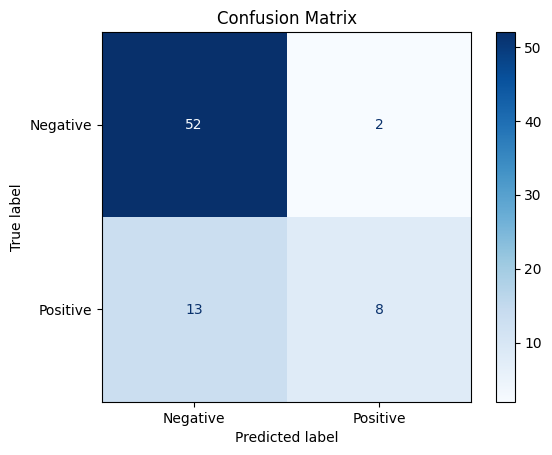


Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.96      0.87        54
    Positive       0.80      0.38      0.52        21

    accuracy                           0.80        75
   macro avg       0.80      0.67      0.70        75
weighted avg       0.80      0.80      0.77        75

Number of selected features: 88
Shape of SHAP values: (260, 88)


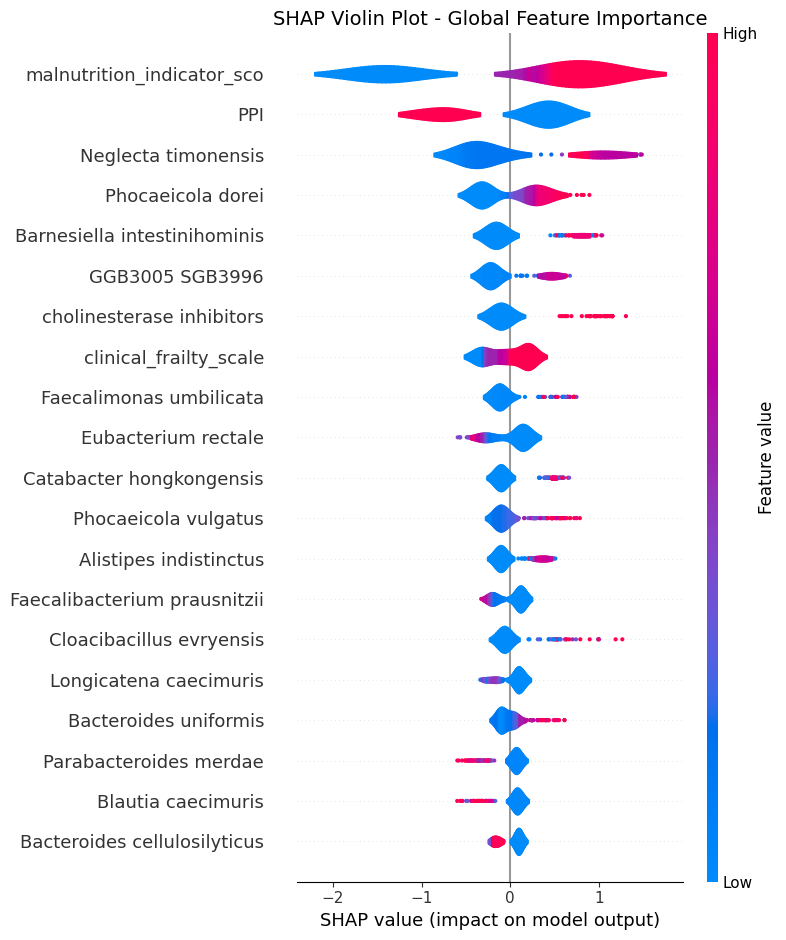

Overlap bacteria found: {'Akkermansia_muciniphila', 'Eggerthellaceae_unclassified_SGB14341', 'Cloacibacillus_evryensis', 'Klebsiella_pneumoniae', 'Dialister_invisus', 'Faecalimonas_umbilicata', 'Anaerotruncus_massiliensis', 'Anaerobutyricum_hallii', 'Romboutsia_timonensis', 'Oscillibacter_sp_ER4', 'Phocaeicola_dorei', 'Phascolarctobacterium_faecium', 'Lachnospiraceae_unclassified_SGB66069', 'Bacteroides_cellulosilyticus', 'Blautia_wexlerae', 'Clostridia_unclassified_SGB4367', 'Bacteroides_uniformis', 'Streptococcus_salivarius', 'Clostridium_symbiosum', 'Eubacterium_rectale', 'Neglecta_timonensis', 'Longicatena_caecimuris', 'Clostridium_leptum', 'Faecalibacterium_prausnitzii', 'Bacteroides_ovatus', 'Alistipes_putredinis', 'Tyzzerella_nexilis', 'Gemmiger_SGB15295', 'GGB3005_SGB3996', 'GGB9699_SGB15216', 'Parabacteroides_merdae', 'Ruminococcaceae_unclassified_SGB15260', 'GGB9347_SGB14313', 'Bacteroides_xylanisolvens', 'Enterocloster_clostridioformis', 'Alistipes_finegoldii', 'Alistipes_in

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.8148148148148148)

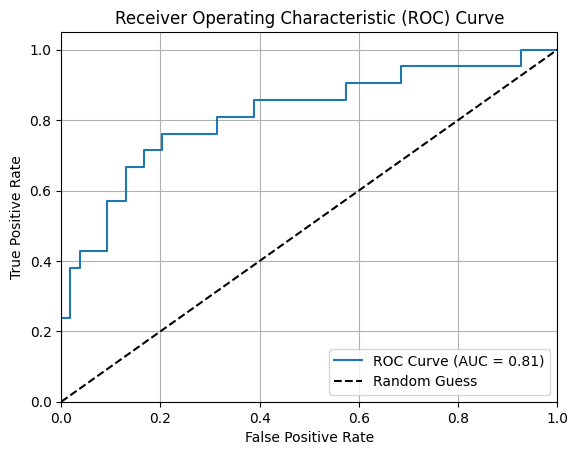

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.8

In [18]:
f1

np.float64(0.5161290322580645)

In [19]:
conf_matrix

array([[52,  2],
       [13,  8]])

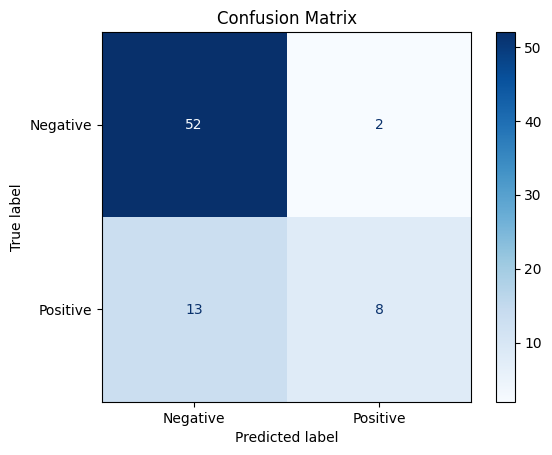

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

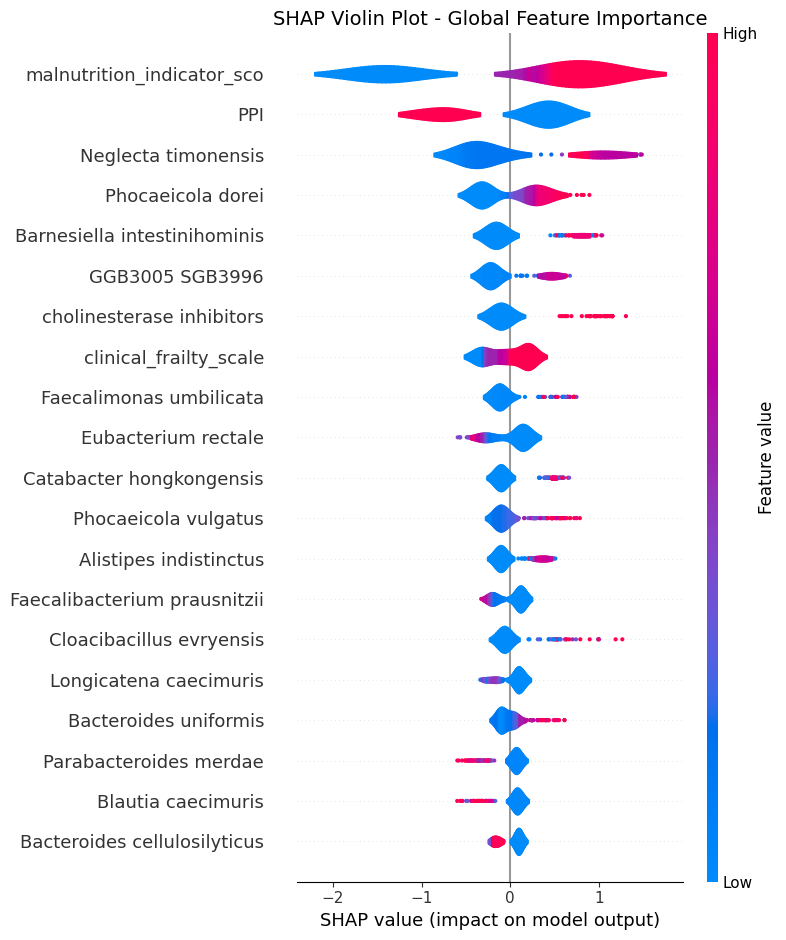

Overlap bacteria found: {'Akkermansia_muciniphila', 'Eggerthellaceae_unclassified_SGB14341', 'Cloacibacillus_evryensis', 'Klebsiella_pneumoniae', 'Dialister_invisus', 'Faecalimonas_umbilicata', 'Anaerotruncus_massiliensis', 'Anaerobutyricum_hallii', 'Romboutsia_timonensis', 'Oscillibacter_sp_ER4', 'Phocaeicola_dorei', 'Phascolarctobacterium_faecium', 'Lachnospiraceae_unclassified_SGB66069', 'Bacteroides_cellulosilyticus', 'Blautia_wexlerae', 'Clostridia_unclassified_SGB4367', 'Bacteroides_uniformis', 'Streptococcus_salivarius', 'Clostridium_symbiosum', 'Eubacterium_rectale', 'Neglecta_timonensis', 'Longicatena_caecimuris', 'Clostridium_leptum', 'Faecalibacterium_prausnitzii', 'Bacteroides_ovatus', 'Alistipes_putredinis', 'Tyzzerella_nexilis', 'Gemmiger_SGB15295', 'GGB3005_SGB3996', 'GGB9699_SGB15216', 'Parabacteroides_merdae', 'Ruminococcaceae_unclassified_SGB15260', 'GGB9347_SGB14313', 'Bacteroides_xylanisolvens', 'Enterocloster_clostridioformis', 'Alistipes_finegoldii', 'Alistipes_in

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (260, 88)


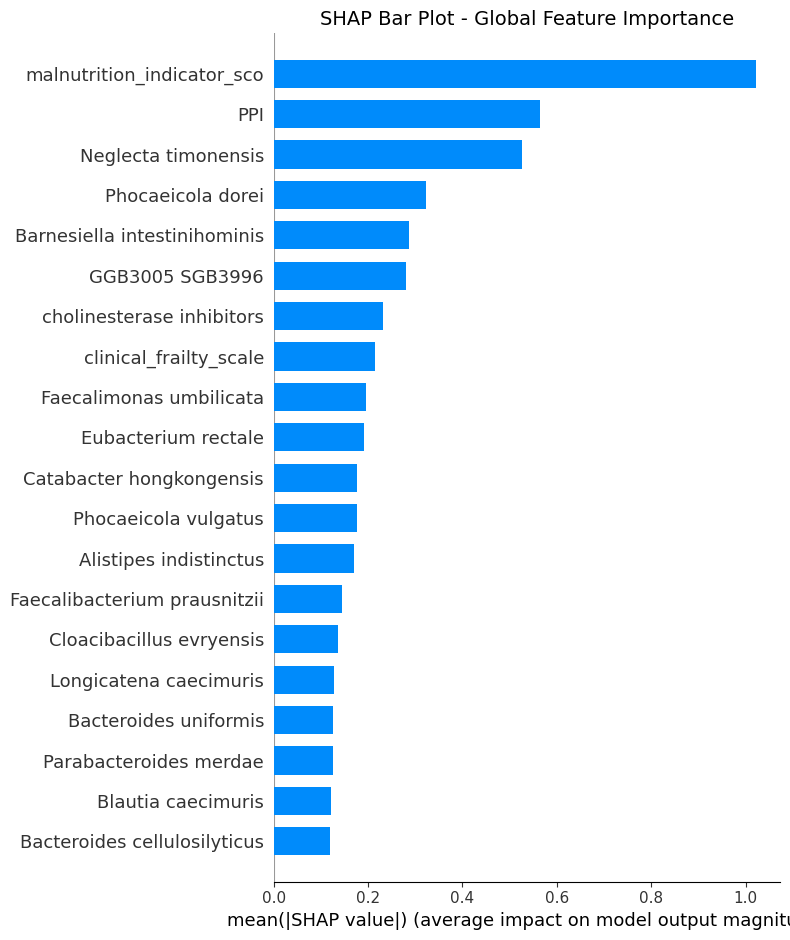

Overlap bacteria found: {'Akkermansia_muciniphila', 'Eggerthellaceae_unclassified_SGB14341', 'Cloacibacillus_evryensis', 'Klebsiella_pneumoniae', 'Dialister_invisus', 'Faecalimonas_umbilicata', 'Anaerotruncus_massiliensis', 'Anaerobutyricum_hallii', 'Romboutsia_timonensis', 'Oscillibacter_sp_ER4', 'Phocaeicola_dorei', 'Phascolarctobacterium_faecium', 'Lachnospiraceae_unclassified_SGB66069', 'Bacteroides_cellulosilyticus', 'Blautia_wexlerae', 'Clostridia_unclassified_SGB4367', 'Bacteroides_uniformis', 'Streptococcus_salivarius', 'Clostridium_symbiosum', 'Eubacterium_rectale', 'Neglecta_timonensis', 'Longicatena_caecimuris', 'Clostridium_leptum', 'Faecalibacterium_prausnitzii', 'Bacteroides_ovatus', 'Alistipes_putredinis', 'Tyzzerella_nexilis', 'Gemmiger_SGB15295', 'GGB3005_SGB3996', 'GGB9699_SGB15216', 'Parabacteroides_merdae', 'Ruminococcaceae_unclassified_SGB15260', 'GGB9347_SGB14313', 'Bacteroides_xylanisolvens', 'Enterocloster_clostridioformis', 'Alistipes_finegoldii', 'Alistipes_in

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1950160822,5,0.8,0.814815,0.516129


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment05_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)